In [1]:
import torch
import numpy as np
from torch.autograd import grad
import matplotlib.pyplot as plt
from torch.nn.functional import mse_loss

In [2]:
x = np.random.rand(100,1)
x = torch.tensor(x, requires_grad=True).float()

In [3]:
net = torch.nn.Sequential(
    torch.nn.Linear(1, 3),
    torch.nn.ELU(),
    torch.nn.Linear(3, 4),
    torch.nn.ELU(),
    torch.nn.Linear(4, 1),
)

tensor([[-0.4310],
        [-0.4267],
        [-0.4223],
        [-0.4180],
        [-0.4137],
        [-0.4093],
        [-0.4050],
        [-0.4006],
        [-0.3963],
        [-0.3920],
        [-0.3876],
        [-0.3833],
        [-0.3790],
        [-0.3746],
        [-0.3703],
        [-0.3660],
        [-0.3616],
        [-0.3573],
        [-0.3530],
        [-0.3486],
        [-0.3443],
        [-0.3400],
        [-0.3356],
        [-0.3313],
        [-0.3270],
        [-0.3227],
        [-0.3183],
        [-0.3140],
        [-0.3097],
        [-0.3054],
        [-0.3011],
        [-0.2967],
        [-0.2924],
        [-0.2881],
        [-0.2838],
        [-0.2795],
        [-0.2752],
        [-0.2709],
        [-0.2665],
        [-0.2622],
        [-0.2579],
        [-0.2536],
        [-0.2493],
        [-0.2450],
        [-0.2407],
        [-0.2364],
        [-0.2321],
        [-0.2278],
        [-0.2235],
        [-0.2192],
        [-0.2149],
        [-0.2106],
        [-0.

(-1.0, 1.0)

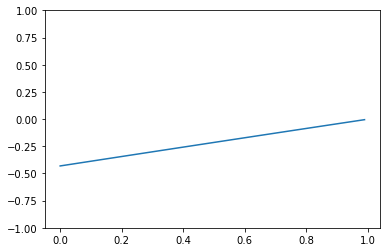

In [4]:
x_test = torch.arange(0, 1, 0.01).float().view(-1, 1)
print(net(x_test))
plt.plot(x_test.detach().numpy(), net(x_test).detach().numpy())
plt.ylim([-1,1])

In [5]:
def loss(net, x):
    # [print(x[i], net(x[i]), grad(net(x[i]), x[i])) for i in range(len(x))]
    # return grad(net(x), x)
    # l = 0
    # for i in range(len(x)):
    #     x_i = x[i]
    #     l += (grad(net(x_i), x_i, create_graph=True)[0] - 1)**2
    # l /= len(x)
    # # print(torch.sum(net(x)))

    l = torch.sum((grad(torch.sum((net(x))), x, create_graph=True)[0] - 1)**2) / x.shape[0]
    # print(l)
    

    l += (net(torch.tensor([[0.]]).float())**2).squeeze()
    return l

l = loss(net, x)
l

tensor(0.5111, grad_fn=<AddBackward0>)

In [6]:
optimizer = torch.optim.Adam(net.parameters(), lr=1)

In [7]:
for step in range(1000):
    l = loss(net, x)
    optimizer.zero_grad()
    l.backward()

    # print the parameters in net, they are initialized automatically
    # for i, par in enumerate(net.parameters()):
    #     if i % 2 == 0:
    #         print("Weights", end=" ")
    #     else:
    #         print("Bias", end=" ")
        
    #     print("between {}-th and {}-th layer:".format(i//2, i//2+1))
    #     # print(par)
    #     print("Gradient:".format(i))
    #     print(par.grad)
    #     print()

    optimizer.step()

    print(loss(net, x))

0.9900, grad_fn=<AddBackward0>)
tensor(0.9897, grad_fn=<AddBackward0>)
tensor(0.9894, grad_fn=<AddBackward0>)
tensor(0.9891, grad_fn=<AddBackward0>)
tensor(0.9887, grad_fn=<AddBackward0>)
tensor(0.9884, grad_fn=<AddBackward0>)
tensor(0.9880, grad_fn=<AddBackward0>)
tensor(0.9876, grad_fn=<AddBackward0>)
tensor(0.9872, grad_fn=<AddBackward0>)
tensor(0.9867, grad_fn=<AddBackward0>)
tensor(0.9862, grad_fn=<AddBackward0>)
tensor(0.9857, grad_fn=<AddBackward0>)
tensor(0.9851, grad_fn=<AddBackward0>)
tensor(0.9845, grad_fn=<AddBackward0>)
tensor(0.9838, grad_fn=<AddBackward0>)
tensor(0.9830, grad_fn=<AddBackward0>)
tensor(0.9822, grad_fn=<AddBackward0>)
tensor(0.9814, grad_fn=<AddBackward0>)
tensor(0.9804, grad_fn=<AddBackward0>)
tensor(0.9794, grad_fn=<AddBackward0>)
tensor(0.9782, grad_fn=<AddBackward0>)
tensor(0.9769, grad_fn=<AddBackward0>)
tensor(0.9755, grad_fn=<AddBackward0>)
tensor(0.9739, grad_fn=<AddBackward0>)
tensor(0.9721, grad_fn=<AddBackward0>)
tensor(0.9700, grad_fn=<AddBackw

(0.0, 1.0)

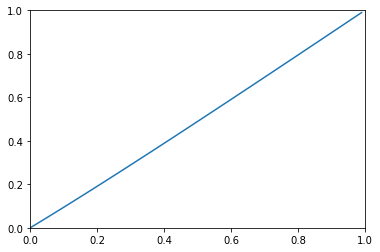

In [8]:
x_test = torch.arange(0, 1, 0.01).float().view(-1, 1)
# print(x_test)
plt.plot(x_test.detach().numpy(), net(x_test).detach().numpy())
plt.ylim([0,1])
plt.xlim([0,1])